In [109]:
# libraries import
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Activation
import numpy as np
import pandas as pd
from keras._tf_keras.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor


In [110]:
df = pd.read_excel('fig3.xlsx')
print(df)

       cycles crack length       cycles.1 crack length.1       cycles.2  \
0         NaN           mm            NaN             mm            NaN   
1    R=0.1,CA     R=0.1,CA  R=0.1,OLR=1.5  R=0.1,OLR=1.5  R=0.1,OLR=2.0   
2        9210      10.2752           9984        10.3196           7528   
3       11186      10.3271          12236         10.371           9281   
4       13372      10.3835          17057         10.423          11247   
..        ...          ...            ...            ...            ...   
245    137559      23.1331         190757         23.223            NaN   
246    137629      23.1878         190838        23.2772            NaN   
247    137691      23.2419         190894        23.3292            NaN   
248    137747      23.2949         190971        23.3804            NaN   
249    137810      23.3462         191033        23.4311            NaN   

    crack length.2  cycles.3 crack length.3       cycles.4 crack length.4  \
0               mm    

In [111]:
# Keep the only first two columns
df1 = df.iloc[:, 0:2]

# Add two new columnns using the first cell of second row
# It can contain one or thow values in form of R=some or OLR=some
# We shoudl parse it and add two new columns
df1['R'] = df1.iloc[1, 0].split('R=')[1].split(',')[0] if 'R=' in df1.iloc[1, 0] else None
df1['OLR'] = df1.iloc[1, 0].split('OLR=')[1] if 'OLR=' in df1.iloc[1, 0] else None


# Remove the first and second row
df1 = df1.iloc[2:, :]

print(df1)


     cycles crack length    R   OLR
2      9210      10.2752  0.1  None
3     11186      10.3271  0.1  None
4     13372      10.3835  0.1  None
5     15492      10.4358  0.1  None
6     17102      10.4875  0.1  None
..      ...          ...  ...   ...
245  137559      23.1331  0.1  None
246  137629      23.1878  0.1  None
247  137691      23.2419  0.1  None
248  137747      23.2949  0.1  None
249  137810      23.3462  0.1  None

[248 rows x 4 columns]


/tmp/ipykernel_137358/2228567306.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['R'] = df1.iloc[1, 0].split('R=')[1].split(',')[0] if 'R=' in df1.iloc[1, 0] else None
/tmp/ipykernel_137358/2228567306.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['OLR'] = df1.iloc[1, 0].split('OLR=')[1] if 'OLR=' in df1.iloc[1, 0] else None


In [112]:
# Split the data into experiments
E1 = df.iloc[:, 0:2]
E1 = E1.iloc[2:, :]
E1.columns = ['cycles', 'crack length']
E1['R'], E1['OLR'] = 0.1, None

E2 = df.iloc[:, 2:4]
E2 = E2.iloc[2:, :]
E2.columns = ['cycles', 'crack length']
E2['R'], E2['OLR'] = 0.1, 1.5

E3 = df.iloc[:, 4:6]
E3 = E3.iloc[2:, :]
E3.columns = ['cycles', 'crack length']
E3['R'], E3['OLR'] = 0.1, 2.0

E4 = df.iloc[:, 6:8]
E4 = E4.iloc[2:, :]
E4.columns = ['cycles', 'crack length']
E4['R'], E4['OLR'] = 0.3, None

E5 = df.iloc[:, 8:10]
E5 = E5.iloc[2:, :]
E5.columns = ['cycles', 'crack length']
E5['R'], E5['OLR'] = 0.3, 1.5

E6 = df.iloc[:, 10:12]
E6 = E6.iloc[2:, :]
E6.columns = ['cycles', 'crack length']
E6['R'], E6['OLR'] = 0.3, 2.0

E7 = df.iloc[:, 12:14]
E7 = E7.iloc[2:, :]
E7.columns = ['cycles', 'crack length']
E7['R'], E7['OLR'] = 0.5, None

E8 = df.iloc[:, 14:16]
E8 = E8.iloc[2:, :]
E8.columns = ['cycles', 'crack length']
E8['R'], E8['OLR'] = 0.5, 1.5

E9 = df.iloc[:, 16:18]
E9 = E9.iloc[2:, :]
E9.columns = ['cycles', 'crack length']
E9['R'], E9['OLR'] = 0.5, 2.0

E10 = df.iloc[:, 18:20]
E10 = E10.iloc[2:, :]
E10.columns = ['cycles', 'crack length']
E10['R'], E10['OLR'] = 0.7, None

E11 = df.iloc[:, 20:22]
E11 = E11.iloc[2:, :]
E11.columns = ['cycles', 'crack length']
E11['R'], E11['OLR'] = 0.7, 1.5

E12 = df.iloc[:, 22:24]
E12 = E12.iloc[2:, :]
E12.columns = ['cycles', 'crack length']
E12['R'], E12['OLR'] = 0.7, 2.0

# Concatenate all the experiments into one dataframe
data = pd.concat([E1, E2, E3, E4, E5, E6, E7, E8, E9, E10, E11, E12])

# Remove the rows with NaN values
data = data.dropna()


/tmp/ipykernel_137358/3115824146.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([E1, E2, E3, E4, E5, E6, E7, E8, E9, E10, E11, E12])


In [113]:
print(data.shape)

print(data.head())

# Check for missing values
print("Train data missing values:")
print(data.isna().values.any())

# Check for empty values
print("Train data empty values:")
print(data.isnull().values.any())

# Check for duplicate rows
print("Train data duplicate rows:")
print(data.duplicated().values.any())



(1650, 4)
  cycles crack length    R  OLR
2   9984      10.3196  0.1  1.5
3  12236       10.371  0.1  1.5
4  17057       10.423  0.1  1.5
5  19425      10.4742  0.1  1.5
6  21109      10.5272  0.1  1.5
Train data missing values:
False
Train data empty values:
False
Train data duplicate rows:
False


In [114]:
X = data.drop('crack length', axis=1).values
y = data['crack length'].values

print(X.shape)
print(y.shape)

(1650, 3)
(1650,)


In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size = .8)

scaler = MinMaxScaler(feature_range = (0, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(np.mean(X), np.std(X))
print(np.mean(X_train_scaled), np.std(X_train_scaled))

99646.88987879074 188248.41597717375
0.4594176773115333 0.39872327236145244


/home/mholubovskyi/work/opensource/ml/qste340tm-modeling-of-fatigue-failure-after-single-overload/.venv/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


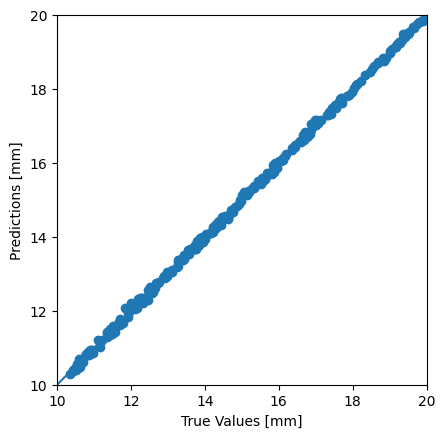

In [116]:
# Define the random forest model
regressor = RandomForestRegressor(n_estimators=10, random_state=0, oob_score=True)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
a = plt.axes(aspect='equal')
plt.scatter(y_test, y_pred)
plt.xlabel('True Values [mm]')
plt.ylabel('Predictions [mm]')
lims = [10, 20]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
plt.show()


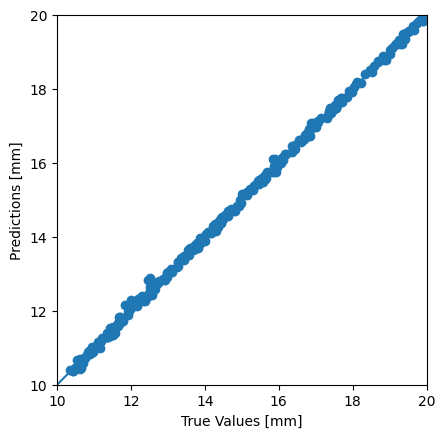

In [117]:
# Define the decision tree model
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor(max_depth=12)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

a = plt.axes(aspect='equal')
plt.scatter(y_test, y_pred)
plt.xlabel('True Values [mm]')
plt.ylabel('Predictions [mm]')
lims = [10, 20]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
plt.show()


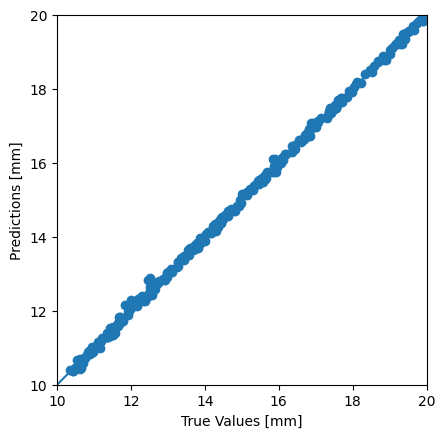

In [118]:
# Define the support vector machine model
from sklearn import svm
model = svm.SVR()
model.fit(X_train_scaled, y_train)
predictions = model.predict(X_test)
a = plt.axes(aspect='equal')
plt.scatter(y_test, y_pred)
plt.xlabel('True Values [mm]')
plt.ylabel('Predictions [mm]')
lims = [10, 20]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
plt.show()